# Biased autoencoder su dati Microarray

Allo scopo di migliorare la compressione, costruiamo una rete neurale simile ad un autoencoder, dove sostituiamo la componente decoder con un classificatore. Anziché performare una ricostruzione dei dati, effettuiamo una classificazione di essi. Utilizzeremo poi la componente encoder per comprimere il dataset.

In [1]:
import pandas as pd 
import numpy  as np

from modules import autoencoder as ae 
from modules import microarray 
from modules import utilities
from modules import postprocess

Salviamo il nome del file contente il dataset.

In [2]:
dataset_file = microarray.get_data_sources()[0]

Salviamo il nome della cartella che conterrà i risultati.

In [29]:
results_directory = 'results/microarray/bias'

## SubBIA: Subtype BIased Autoencoder

Utilizziamo il sottotipo di tumore al seno per veicolare la compressione dei dati. Utilizziamo la funzione `microarray.get_samples_with_label`, che ci permette di inserire, per ogni campione, la relativa label specificata come parametro. Inoltre tale funzione elimina automaticamente ogni record la cui label risutla non definita.

In [9]:
df = microarray.get_samples_with_label('CLAUDIN_SUBTYPE')
df.head()

,RNF165,PHF7,CIDEA,TENT2,SLC17A3,SDS,ATP6V1C2,F3,FAM71C,LIN52,CLAUDIN_SUBTYPE
MB-0362,-0.539,-0.5288,-0.0428,-1.1005,0.7652,0.9422,-0.5147,-1.4466,0.2558,1.3792,LumA
MB-0346,0.2795,-1.2666,-1.0604,-0.1582,-0.5049,-0.5246,3.9497,-1.2455,-0.8398,1.0669,Her2
MB-0386,-0.7587,0.0692,3.2405,-0.9619,0.6749,0.196,-0.2159,-1.071,-1.419,0.3337,LumA
MB-0574,-1.1358,-0.4942,-0.2908,2.2928,-1.0863,0.0116,-0.383,-1.1789,0.86,0.2752,LumA
MB-0503,-0.7617,-0.136,1.2219,0.9885,-1.2386,0.4852,-0.6472,-1.0173,-0.4554,1.1501,LumA


In [11]:
df.rename(columns={'CLAUDIN_SUBTYPE': 'SUBTYPE'}, inplace=True)

Rimuoviamo i record con sottotipo NC (Not classified)

In [16]:
not_classified_records = df['SUBTYPE'] == 'NC'
df = df[-not_classified_records]

## Preparazione dei dati di training

In [17]:
nclasses = len(df['SUBTYPE'].unique())
print(f"Non considerando la classe nulla, vi sono {nclasses} classi")

Non considerando la classe nulla, vi sono 6 classi


Partizioniamo il dataset, facendo attenzione al problema del campionamento per la classificazione multiclasse. 
È necessario utilizzare un label encoder per convertire la label SUBTYPE in un valore categoriale.

In [18]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

npoints, nfeatures = df.shape
nfeatures -= 1 # remove the SUBTYPE count

train_set, valid_set =  utilities.multilabel_train_test_split(df, 'SUBTYPE', .2)
train_set, test_set  =  utilities.multilabel_train_test_split(train_set,   'SUBTYPE', .2)

label_encoder = LabelEncoder()
label_encoder.fit(df['SUBTYPE'].unique())

takex = lambda _ds: _ds.drop(['SUBTYPE'], axis=1)
takey = lambda _ds: to_categorical(label_encoder.transform(_ds['SUBTYPE']))
x_train, x_test, x_valid = takex(train_set), takex(test_set), takex(valid_set) 
y_train, y_test, y_valid = takey(train_set), takey(test_set), takey(valid_set)

### Costruzione del modello

In [19]:
autoencoder_structure = ae.biased_autoencoder(nclasses).get('SubBIA')

In [20]:
enc = autoencoder_structure.get('encoder')
clf = autoencoder_structure.get('classifier')
SubBIA = ae.generate_biased_autoencoder(nfeatures, enc, clf)

Epoch 1/2
5/5 [==============================] - 12s 2s/step - loss: 2.0871 - accuracy: 0.2536 - val_loss: 2.0054 - val_accuracy: 0.1283
Epoch 2/2
5/5 [==============================] - 9s 2s/step - loss: 1.5704 - accuracy: 0.4007 - val_loss: 1.9167 - val_accuracy: 0.2401


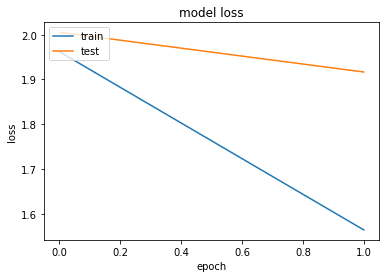

In [21]:
from keras.callbacks import EarlyStopping

earlystopping = EarlyStopping(monitor='val_loss',\
                              verbose=1, patience=40,\
                              restore_best_weights=True)

SubBIA_history = SubBIA.fit(np.asarray(x_train).astype(np.float32), y_train,
            epochs=2, 
            batch_size=256,
            shuffle=True,
            verbose=1,
            callbacks=[earlystopping],
            validation_data=(np.asarray(x_test).astype(np.float32), y_test))

postprocess.plot_history(SubBIA_history)

### Valutazione del modello SubBIA

In [23]:
loss, acc = SubBIA.evaluate(np.asarray(x_valid).astype(np.float32), y_valid, verbose=0)
loss, acc

(1.9652329683303833, 0.19473683834075928)

### Salvataggio dei dataset compressi

In [25]:
encpos = autoencoder_structure.get('encoder_position')

ds = df.drop('SUBTYPE', axis=1)

enc150f = ae.extract_encoder(SubBIA, encpos.get(150))
red_ds_150 = pd.DataFrame(enc150f.predict(np.asarray(ds).astype('float32')))
red_ds_150.index = ds.index

enc50f = ae.extract_encoder(SubBIA, encpos.get(50))
red_ds_50 = pd.DataFrame(enc50f.predict(np.asarray(ds).astype('float32')))
red_ds_50.index = ds.index

enc25f = ae.extract_encoder(SubBIA, encpos.get(25))
red_ds_25 = pd.DataFrame(enc25f.predict(np.asarray(ds).astype('float32')))
red_ds_25.index = ds.index

In [30]:
postprocess.save_compressed_dataset(red_ds_150, loss, results_directory, dataset_file)
postprocess.save_compressed_dataset(red_ds_50,  loss, results_directory, dataset_file)
postprocess.save_compressed_dataset(red_ds_25,  loss, results_directory, dataset_file)